In [3]:
import pandas as pd

In [4]:
data = pd.read_csv("flipkart_product_review.csv")

In [5]:
data.head()

,product_id,product_title,rating,summary,review
0,ACCFZGAQJGYCYDCM,BoAt Rockerz 235v2 with ASAP charging Version ...,5,Terrific purchase,1-more flexible2-bass is very high3-sound clar...
1,ACCFZGAQJGYCYDCM,BoAt Rockerz 235v2 with ASAP charging Version ...,5,Terrific purchase,Super sound and good looking I like that prize
2,ACCFZGAQJGYCYDCM,BoAt Rockerz 235v2 with ASAP charging Version ...,5,Super!,Very much satisfied with the device at this pr...
3,ACCFZGAQJGYCYDCM,BoAt Rockerz 235v2 with ASAP charging Version ...,5,Super!,"Nice headphone, bass was very good and sound i..."
4,ACCFZGAQJGYCYDCM,BoAt Rockerz 235v2 with ASAP charging Version ...,5,Terrific purchase,Sound quality super battery backup super quali...


In [6]:
data.shape

(450, 5)

#### Installing Dependencies

In [7]:
%pip install -q langchain



Note: you may need to restart the kernel to use updated packages.


In [8]:
import langchain

In [9]:
%pip install -q langchain-community
%pip install -q langchain-astradb
%pip install -q langchain-groq
%pip install -q pypdf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
data.columns

Index(['product_id', 'product_title', 'rating', 'summary', 'review'], dtype='object')

In [11]:
data =  data[['product_title','review']]

In [12]:
data.head(3)

,product_title,review
0,BoAt Rockerz 235v2 with ASAP charging Version ...,1-more flexible2-bass is very high3-sound clar...
1,BoAt Rockerz 235v2 with ASAP charging Version ...,Super sound and good looking I like that prize
2,BoAt Rockerz 235v2 with ASAP charging Version ...,Very much satisfied with the device at this pr...


#### convert data in document format

In [13]:
product_list = []
for index, row in data.iterrows():
    object = {
        'product_name':row['product_title'],
        'review':row['review']
    }
    product_list.append(object)

In [14]:
product_list[0]

{'product_name': 'BoAt Rockerz 235v2 with ASAP charging Version 5.0 Bluetooth Headset',
 'review': "1-more flexible2-bass is very high3-sound clarity is good 4-battery back up to 6 to 8 hour's 5-main thing is fastest charging system is available in that. Only 20 min charge and get long up to 4 hours back up 6-killing look awesome 7-for gaming that product does not support 100% if you want for gaming then I'll recommend you please don't buy but you want for only music then this product is very well for you.. 8-no more wireless headphones are comparing with that headphones at this pric..."}

In [15]:
from langchain_core.documents import Document

In [16]:
docs = []
for object in product_list:
    metadata = {'product_name':object['product_name']}
    page_content = object['review']

    doc = Document(page_content=page_content,metadata=metadata)
    docs.append(doc)

In [17]:
docs[0]

Document(metadata={'product_name': 'BoAt Rockerz 235v2 with ASAP charging Version 5.0 Bluetooth Headset'}, page_content="1-more flexible2-bass is very high3-sound clarity is good 4-battery back up to 6 to 8 hour's 5-main thing is fastest charging system is available in that. Only 20 min charge and get long up to 4 hours back up 6-killing look awesome 7-for gaming that product does not support 100% if you want for gaming then I'll recommend you please don't buy but you want for only music then this product is very well for you.. 8-no more wireless headphones are comparing with that headphones at this pric...")

In [18]:
len(docs)

450

In [19]:
%pip install python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
from dotenv import load_dotenv

In [21]:
# Load environment variables from .env file
load_dotenv()

True

In [22]:
# Access the variables
GROQ_API = os.getenv('GROQ_API')
HF_TOKEN = os.getenv('HF_TOKEN')
ASTRA_DB_APPLICATION_TOKEN = os.getenv('ASTRA_DB_APPLICATION_TOKEN')
ASTRA_DB_API_ENDPOINT = os.getenv('ASTRA_DB_API_ENDPOINT')
ASTRA_DB_KEYSPACE = os.getenv('ASTRA_DB_KEYSPACE')


In [23]:
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings


In [24]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

In [25]:
embeddings = HuggingFaceInferenceAPIEmbeddings(api_key=HF_TOKEN,model_name='BAAI/bge-base-en-v1.5')

In [26]:
from langchain_astradb import AstraDBVectorStore

In [27]:
vstore = AstraDBVectorStore(
    embedding=embeddings,
    collection_name='flipkart',
    api_endpoint=ASTRA_DB_API_ENDPOINT,
    token=ASTRA_DB_APPLICATION_TOKEN,
    namespace=ASTRA_DB_KEYSPACE
)

In [28]:
insert_ids = vstore.add_documents(docs) 

In [29]:
from langchain_groq import ChatGroq

In [30]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import MessagesPlaceholder
from langchain.chains import create_history_aware_retriever

In [31]:
model = ChatGroq(groq_api_key=GROQ_API,model='llama-3.1-70b-versatile',temperature=0.5)

#### allowing memory
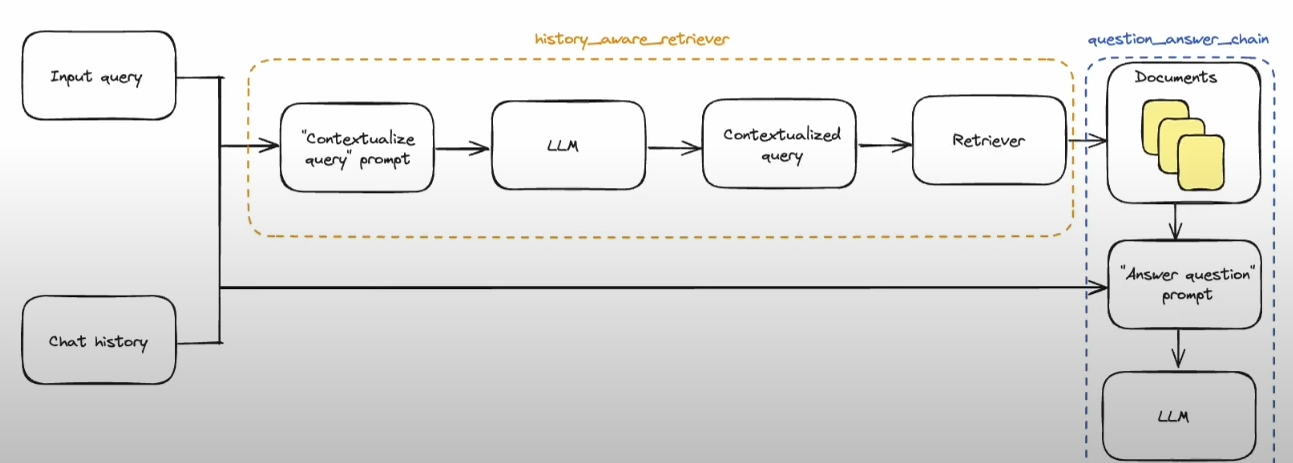

In [32]:
retriever_prompt = ('Given a chat history and the latest user question which might reference context in the chat history,''formulate a standalone which can be understood without the  chat history.'
                    'DO NOT answer the question,just reformulate it if needed and otherwise return it as is.')

In [33]:
retriever = vstore.as_retriever(search_kwargs = {'k':3})

In [34]:
from langchain_core.prompts import ChatPromptTemplate

In [35]:
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',retriever_prompt),
        MessagesPlaceholder(variable_name='chat_history'),

        ('human','{input}')
    ]
)

In [36]:
history_aware_retriever = create_history_aware_retriever(model,retriever, contextualize_q_prompt)

In [37]:
PRODUCT_BOT_TEMPLATE = '''
    Your ecommerce bot is an expert in product recommendations and customer queries. It analyzes product titles and reviews to provide accurate and helpful responses.
    Ensure your answers are relevant to the  product  context and refrain from straying off-topic.
    Your responses should be concise and informative

    CONTEXT:{context}
    QUESTION:{input}
    YOUR ANSWER:

'''

In [38]:
qa_prompt =  ChatPromptTemplate.from_messages(
    [
        ('system',PRODUCT_BOT_TEMPLATE),
        MessagesPlaceholder(variable_name='chat_history'),

        ('human','{input}') 
    ]
)

In [39]:
question_answer_chain = create_stuff_documents_chain(model,qa_prompt)

In [40]:
chain = create_retrieval_chain(history_aware_retriever,question_answer_chain)

In [41]:
chat_history = []

In [42]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

In [43]:
store = {}

In [50]:
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        # Initialize a new ChatMessageHistory object if session_id is not found
        store[session_id] = ChatMessageHistory()
    # Return the existing or newly created ChatMessageHistory object
    return store[session_id]

In [51]:
chain_with_memory = RunnableWithMessageHistory(
    chain,
    get_session_history,
    input_messages_key='input',
    history_messages_key= 'chat_history',
    output_messages_key='answer',
)

In [52]:
chain_with_memory.invoke(
    {'input':'can you tell me the best bluetooth buds'},
    config={
        'configurable':{'session_id':'abhishek'}
    },
)['answer']

'Two options are highly recommended: \n\n1. Realme Bluetooth headset: Known for its astonishing bass, excellent sound quality, and long battery life (up to 10 hours). It also has a smooth design and good build quality.\n\n2. One Plus Bluetooth earphones: Praised for its superb sound quality, good bass, and very good built quality. It also offers up to 15 hours of playback.'

In [53]:
store

{'abhishek': InMemoryChatMessageHistory(messages=[HumanMessage(content='can you tell me the best bluetooth buds', additional_kwargs={}, response_metadata={}), AIMessage(content='Based on the reviews, I would recommend the Realme Buds 2. They are considered the best earphone under this price range with boosted bass, good sound quality, and long battery life (up to 7 days on a single charge). They are also waterproof, making them suitable for gym use.', additional_kwargs={}, response_metadata={}), HumanMessage(content='can you tell me the best bluetooth buds', additional_kwargs={}, response_metadata={}), AIMessage(content='Two options are highly recommended: \n\n1. Realme Bluetooth headset: Known for its astonishing bass, excellent sound quality, and long battery life (up to 10 hours). It also has a smooth design and good build quality.\n\n2. One Plus Bluetooth earphones: Praised for its superb sound quality, good bass, and very good built quality. It also offers up to 15 hours of playba

In [54]:
chain_with_memory.invoke(
    {'input':'what is my last question?'},
    config={
        'configurable':{'session_id':'abhishek'}
    },
)['answer']

'Your last question was "can you tell me the best bluetooth buds"'

In [55]:
# Test get_session_history separately
print(get_session_history('abhishek'))

Human: can you tell me the best bluetooth buds
AI: Based on the reviews, I would recommend the Realme Buds 2. They are considered the best earphone under this price range with boosted bass, good sound quality, and long battery life (up to 7 days on a single charge). They are also waterproof, making them suitable for gym use.
Human: can you tell me the best bluetooth buds
AI: Two options are highly recommended: 

1. Realme Bluetooth headset: Known for its astonishing bass, excellent sound quality, and long battery life (up to 10 hours). It also has a smooth design and good build quality.

2. One Plus Bluetooth earphones: Praised for its superb sound quality, good bass, and very good built quality. It also offers up to 15 hours of playback.
Human: what is my last question?
AI: Your last question was "can you tell me the best bluetooth buds"
